In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")


  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


In [2]:
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie

In [3]:
Makie.inline!(true)

true

Dona error, suposo que amb els comentaris he tocat algo

In [6]:
rods2DChemotaxis = ABM(2,   #Dimensions del model
    agent = Dict(           #Característiques dels agents
            :vx=>Float64,   #Velocitat en x
            :vy=>Float64,   #Velocitat en y
            :theta=>Float64,    #Angle de l'orientació de la bacteria
            :ω=>Float64,    #Velocitat angular
            :d=>Float64,    #Diametre
            :l=>Float64,    #Longitud
            :m=>Float64,    #Massa
            :fx=>Float64,   #Força de repulsió en x
            :fy=>Float64,   #Força de repulió en y
            :W=>Float64,    #Moment angular
            :pressure=>Float64  #Pressió sobre la bacteria
            :tTumble=>Float64, #We add to the agent a time to tumble or to run -- temps per tumble 
            :active=>Bool,     #Add a switch to change between tumbling and running
        ),

    model = Dict(
            :kn=>Float64,   #Força de repulsió
            :γn=>Float64,   #Constant de fricció de velocitat normal
            :γt=>Float64,   #Constant de fricció de velocitat tangencial
            :μcc=>Float64,  #Constant de fricció rod - rod (bacteria a bacteria)
            :μcw=>Float64,  #Constant de fricció rod-pared (bacteria pared)
            :β=>Float64,    #Constant de fricció
            :βω=>Float64,   #Constant de fricció angular
            :ωTumble=>Float64,      #Add a torque of tumbling -- intensitat del tumble (mes alt, mes brsc el canvi de direcció)
            :τTumble=>Float64,       #Add a frequency of tumbling -- temps entre tumbles (mes alt, runs mes llargs)
            :fChem=>Float64,   #Add a force of propulsion -- propulsió pròpia del rod (més alt, més rapides)
            :DMedium=>Float64, #Add a diffusion constant of the medium - difusió del químic dins el medi
            :ωMedium=>Float64  #Add a frequency of the oscillating medium - oscil·lació del medi
        ),

    medium = Dict(
        :mm => Float64        #Add a medium parameter -- concenctració del químic
    ),

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin  #Passa per una bacteria els veins propers

            Fijx, Fijy, Wij = CBMModels.rodForces(  #Calcula interacció mecànica entre les bacteries. 
                                    x,y,d,l,theta,vx,vy,m, #Bacteria actual
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2], #Bacteria veïna
                                    kn,γn,γt,μcc,μcw #Paràmetres del medi
                                )

            #Append the interaction forces
            fx += Fijx  #Força de j sobre i (veina sobre actual)
            fy += Fijy
            #Append radial forces
            W += Wij    #Torque de j sobre i 
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)     #Mesura pressió local, estrés mecànic
            
        end

        #Equations
        dt(x) =  vx     #Velocitat en x
        dt(y) =  vy     #Velocitat en y
        dt(vx) =  -β*vx+fx/m + active * fChem * cos(theta) #Add the propulsion force -- friccio (beta) per la velocitat, forces d'interaccio entre la massa si esta activa, fChem propulsió pels falgels modulada per senyal quimica 
        dt(vy) =  -β*vy+fy/m + active * fChem * sin(theta) #Add the propulsion force
        dt(theta) =  ω  #Si theta 0 = va recta, si theta=/ 0 gira
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω    #W torque total degut a colisions/contacte)
            #Denominador = moment d'inèrcia (longitud, forma rod, correcció per grossor), quan mes llarga/pesada = més difícil fer que giri. 
            #Terme negatiu = fricció angular (pèrdua energia)
        
    end,

    agentRule = quote
        #Code rule switch between tumbling and running
        if tTumble < t && active #Activate tumbling if the particle was active (running) and the tumbling time ended
            vx = 0               #tTumble ha acabat - canviara de run a tumble, active false = tumble, es para (velocitat 0)
            vy = 0               
            active = false
            ω += ωTumble        #Aplica torque a la velocitat angular
            tTumble += 1.       #Duració del temps de tumble
        elseif tTumble < t && !active # Activate tumbling if the particle was tumbling (active off) and the running time ended (we resuse the tTumble time)
            ω = 0               #Acaba el tumble
            active = true       #Torna a run
            tTumble += CBMDistributions.exponential((2-mm)*τTumble)  #Determina si es attractant o repellent
        end         #Funció determina el temps que durarà el run - mm = concnetració local del químic, a concentració alta del químic 

        # Very rudementary rule to to fix the bacteries to move inside the boundaries using onluy the center of the rod
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end

    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(mm) = DMedium*@∂2(1,mm)# we only diffuse in x as the symmetry is in x
        elseif @mediumBorder(1,-1)
            mm = 0
        elseif @mediumBorder(1,1)
            mm = sin(ωMedium*t)+1 #Oscillatory behaviour
        elseif @mediumBorder(2,-1)
            mm = 0
        elseif @mediumBorder(2,-1)
            mm = 0
        end
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4)    #Determina el rang d'interacció - quines bacteries son veïnes. 3 + 1 = 4 (d +l). Adjudica una cèl·lula a cada bacteri i nomes considera les que estan a la mateixa o a les adjacents. 4 = tamany d'aquesta. 
);      #Més gran tamany = més veins i més complexitat de càlcul/computació

UndefVarError: UndefVarError: `tTumble` not defined

Nou copia i pega del codi igual sense comentaris

In [ ]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
            :vx=>Float64,
            :vy=>Float64,
            :theta=>Float64,
            :ω=>Float64,
            :d=>Float64,
            :l=>Float64,
            :m=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
            :tTumble=>Float64, #We add to the agent a time to tumble or to run
            :active=>Bool,     #Add a switch to change between tumbling and running
        ),

    model = Dict(
            :kn=>Float64,
            :γn=>Float64,
            :γt=>Float64,
            :μcc=>Float64,
            :μcw=>Float64,
            :β=>Float64,
            :βω=>Float64,
            :ωTumble=>Float64, #Add a torque of tumbling
            :τTumble=>Float64, #Add a frequency of tumbling
            :fChem=>Float64,   #Add a force of propulsion
            :DMedium=>Float64, #Add a diffusion constant of the medium
            :ωMedium=>Float64  #Add a frequency of the oscillating medium
        ),

    medium = Dict(
        :mm => Float64        #Add a medium parameter
    ),

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            #Append the interaction forces
            fx += Fijx
            fy += Fijy
            #Append radial forces
            W += Wij
            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m + active * fChem * cos(theta) #Add the propulsion force
        dt(vy) =  -β*vy+fy/m + active * fChem * sin(theta) #Add the propulsion force
        dt(theta) =  ω
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 
        
    end,

    agentRule = quote
        #Code rule switch between tumbling and running
        if tTumble < t && active #Activate tumbling if the particle was active (running) and the tumbling time ended
            vx = 0
            vy = 0
            active = false
            ω += ωTumble
            tTumble += 1.
        elseif tTumble < t && !active # Activate tumbling if the particle was tumbling (active off) and the running time ended (we resuse the tTumble time)
            ω = 0
            active = true
            tTumble += CBMDistributions.exponential((2-mm)*τTumble) #Changed to 2 + mm to replicate negative chemotaxis
        end

        # Very rudementary rule to to fix the bacteries to move inside the boundaries using onluy the center of the rod
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end

    end,

    #Medium dynamics with dirichlet conditions and a wall that is as oscillating source of material
    mediumODE=quote 
        if @mediumInside()
            dt(mm) = DMedium*@∂2(1,mm)# we only diffuse in x as the symmetry is in x
        elseif @mediumBorder(1,-1)
            mm = 0
        elseif @mediumBorder(1,1)
            mm = sin(ωMedium*t)+1 #Oscillatory behaviour
        elseif @mediumBorder(2,-1)
            mm = 0
        elseif @mediumBorder(2,-1)
            mm = 0
        end
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4)
);

In [8]:
com = Community(
    rods2DChemotaxis,   #Model
    N=75,   #Nombre d'agents al sistema
    dt=0.1, #Time steps
    simBox=[-20 20;-20 20.],    #Espai on es mouen
    NMedium=[200,200],  #Reslució espacial del medi - matriu on està el químic, si es més petit = simulació més gran (cada "punt" de químic ocupa més, menys detall)
)

m = 1/100   #Massa efectiva del agent
g = 1/10000 #Escalal de fricció  - per a treballar a escala amb nombres no tan grans
d = 1 #Diametre característic
com.kn = 2E6      * (m*g/d)     #Interaccions mecàniques entre rods - repulsió
com.γn = 2.2E2    * sqrt(g/d)      #fricció normal i tangencial
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1       #Fricció bacteria - bacteria - pared
com.μcw = 0.8
com.β = .8
com.βω = .8
com.fChem = 1
com.τTumble = 2
# com.τTumbleMin = 1
com.ωTumble = 1
com.ωMedium = .01       #Frequencia d'osculació del medi
com.DMedium = 3     #Coefficient de difusió

com.m = 1.        #Massa, diametre, longitud
com.d = 1.        
com.l = 3;
com.x = rand(Uniform(com.simBox[1,:]...),com.N)     #Posicions inicials aleatòries. 
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N);

In [9]:
length(com)

0

In [10]:
evolve!(com, steps = 8000, saveEach = 10)

In [16]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)

Canvis fets: Point3f0 per Point3f, rotations per rotation. 

In [14]:
1:round(Int,length(com)/4):length(com)

1:200:601

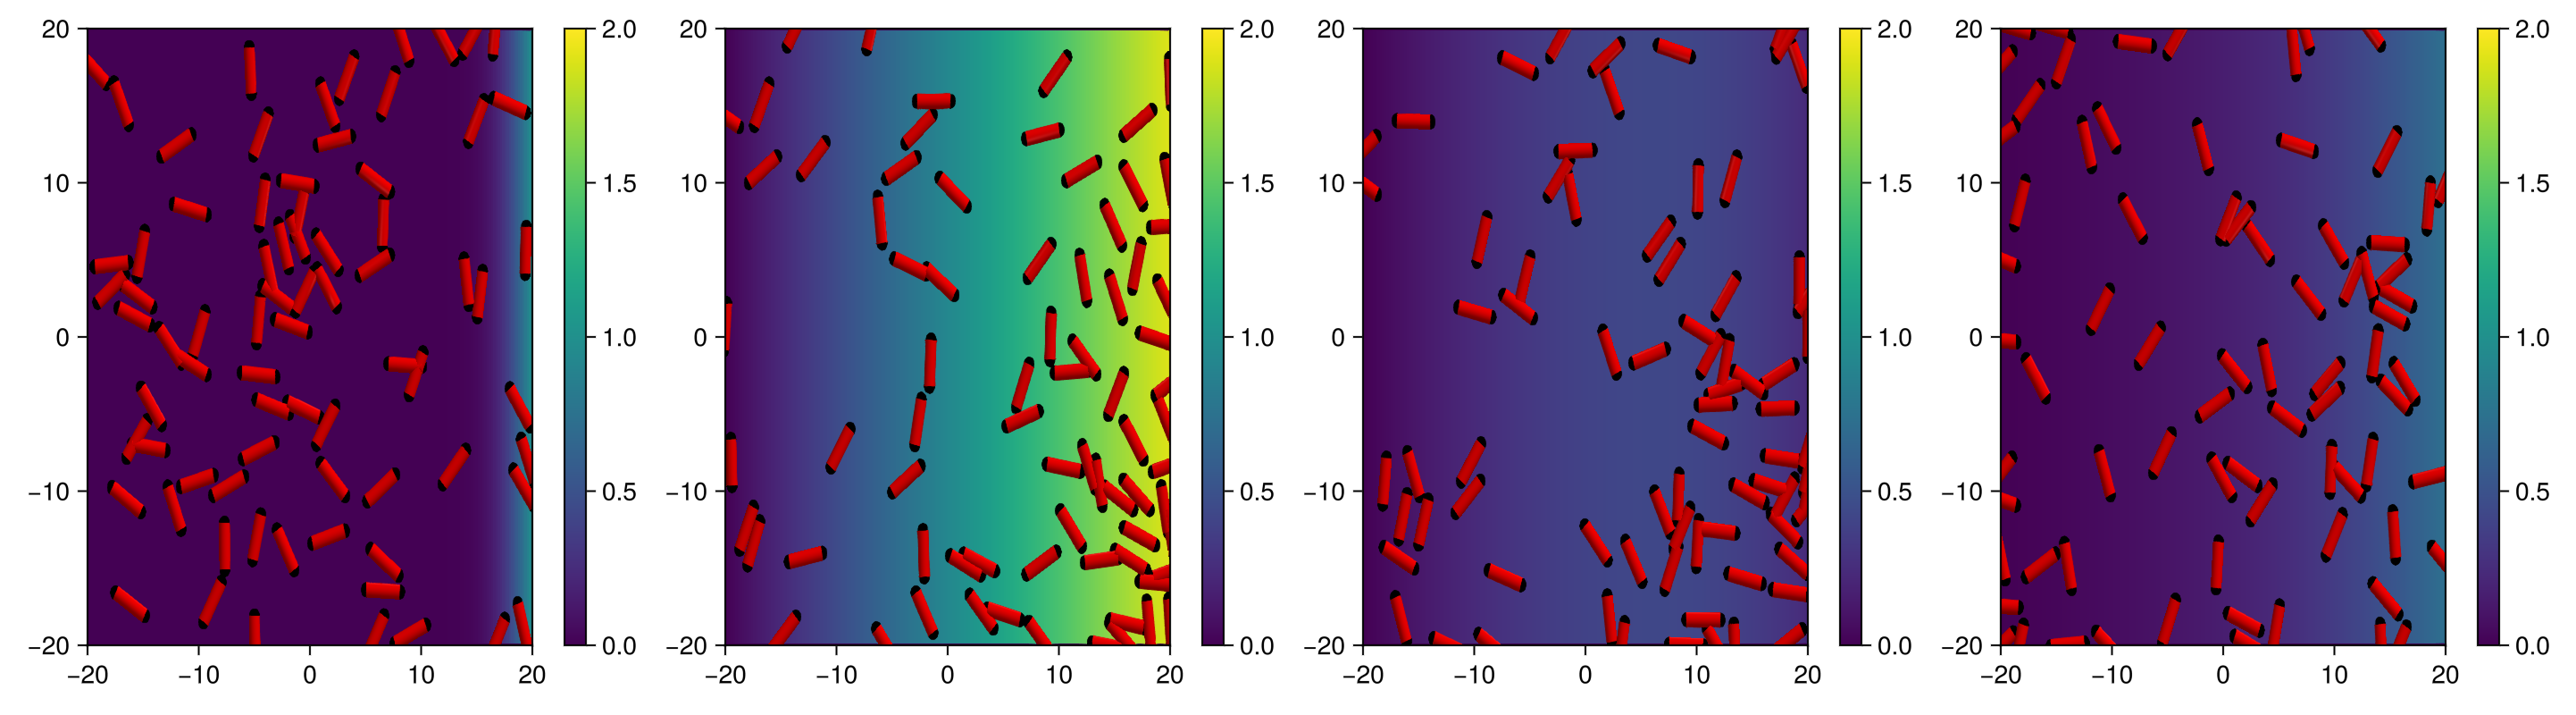

GLMakie.Screen(...)

In [17]:
fig = Figure(size=(1800,400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com,[:x,:y,:d,:l,:theta,:pressure,:mm])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
            )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)
    end
end

display(fig)

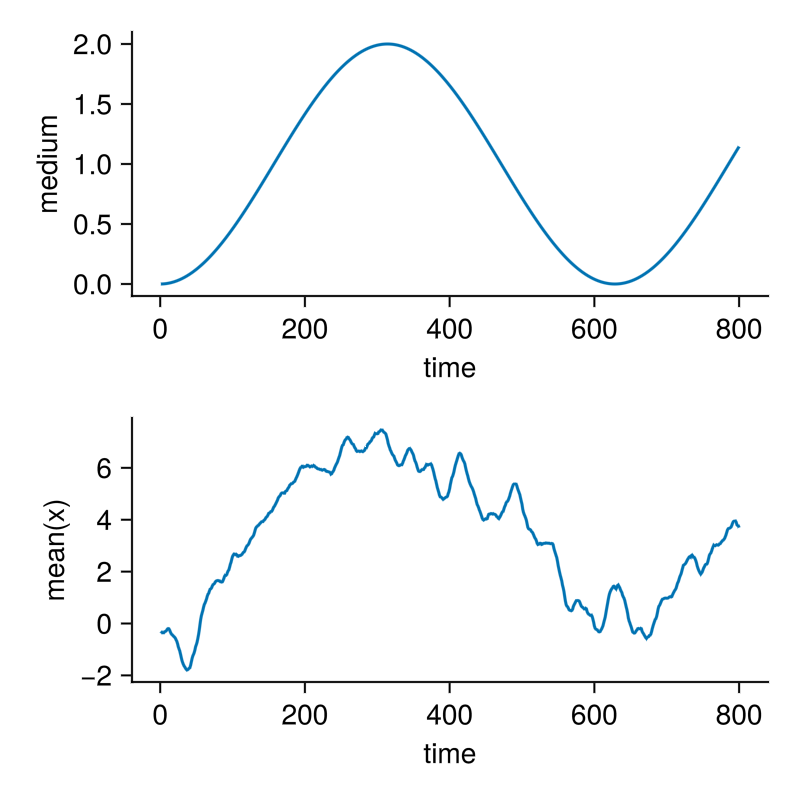

GLMakie.Screen(...)

In [18]:
d = getParameter(com,[:x])

fig = Figure(size=(400,400))
ax = Axis(fig[1,1],xlabel="time",ylabel="medium",
            rightspinevisible=false,
            topspinevisible=false,
            xgridvisible=false,
            ygridvisible=false
        )

lines!(ax,[i.t for i in com.pastTimes],[1-cos(com.ωMedium[1]*i.t) for i in com.pastTimes])

ax2 = Axis(fig[2,1],xlabel="time",ylabel="mean(x)",
            rightspinevisible=false,
            topspinevisible=false,
            xgridvisible=false,
            ygridvisible=false
        )
lines!(ax2,[i.t for i in com.pastTimes],[mean(i) for i in d[:x]])

display(fig)